In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import isnan

sns.set()

In [2]:
output_file = 'results/OzoneCrossVal/results_nn_optimizing_bs_and_lr'

output_file_2 = 'results/OzoneCrossVal/results_final'

total_metrics = pd.read_csv(f'{output_file}.csv')
total_metrics_2 = pd.read_csv(f'{output_file_2}.csv')

total_metrics_2 = total_metrics_2[(total_metrics_2.model_name!='dense')]

total_metrics = pd.concat((total_metrics, total_metrics_2))
total_metrics["n_features"] = total_metrics.selected_features.apply(eval).apply(len)
#total_metrics["selection_params_residual"] = total_metrics.selection_params_residual.fillna(False)

FileNotFoundError: [Errno 2] No such file or directory: 'results/OzoneCrossVal/results_nn_optimizing_bs_and_lr.csv'

In [3]:
total_metrics['model_name'] = total_metrics['model_name'].replace({'decisiontree': 'DT', 'lstm': "LSTM"})
total_metrics['selection_name'] = total_metrics['selection_name'].replace({'NoSelection': 'NS', 'TimeSelectionLayer': 'TSL'})

total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM'), 'model_name'] = 'TLSTM'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense'), 'model_name'] = 'TFF'
total_metrics.loc[total_metrics.selection_name=='TimeSelectionLayerConstant', 'model_name'] = 'TSL*'
#total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.selection_params_residual), 'model_name'] = 'TSLRes'
total_metrics['model_name'] = total_metrics['model_name'].replace({'dense': 'FF', 'lasso': 'L1'})
total_metrics['dataset'] = total_metrics['dataset'].apply(lambda x: x.capitalize()).replace({'Rondadelvalle': 'Ronda del valle'})
total_metrics.drop("dataset_name", inplace=True, axis=1)

In [4]:
model_params = [col for col in total_metrics.columns if 'model_params' in col or 'selection_params' in col]
grouped = total_metrics.groupby(['dataset', 'selection_name', 'model_name', *model_params], dropna=False)[["root_mean_squared_error_valid"]].mean()
best_index = grouped.loc[grouped.groupby(['dataset', 'selection_name', 'model_name', 'selection_params_residual'], dropna=False).root_mean_squared_error_valid.idxmin()].index

total_metrics_indexed = total_metrics.set_index(['dataset', 'selection_name', 'model_name',*model_params])

best_by_year = total_metrics_indexed.loc[best_index, ['root_mean_squared_error', 'mean_absolute_error', 'dataset_params_test_year', 'dataset_params_seq_len', 'features', 'selected_features']].reset_index()

best_by_year[best_by_year.dataset_params_test_year>2005].groupby(['dataset', 'model_name'], dropna=False)[["root_mean_squared_error"]].mean().reset_index().pivot(index = 'dataset', columns='model_name', values='root_mean_squared_error')[["DT", "L1", "FF", "LSTM", "TFF", "TLSTM"]]#.to_latex()

model_name,DT,L1,FF,LSTM,TFF,TLSTM
dataset,,,,,,
Aljarafe,17.171618,16.666747,17.019767,16.492465,16.670537,16.324708
Asomadilla,17.321076,16.338111,17.276939,16.568526,16.513144,16.266460
Bermejales,19.264402,18.220908,18.946476,18.520877,18.139151,18.112180
Ronda del valle,20.244155,18.672663,19.194717,18.706682,18.431709,18.260098
Torneo,14.978726,14.143445,14.619907,14.093802,14.000398,14.018860


<Figure size 1440x1440 with 0 Axes>

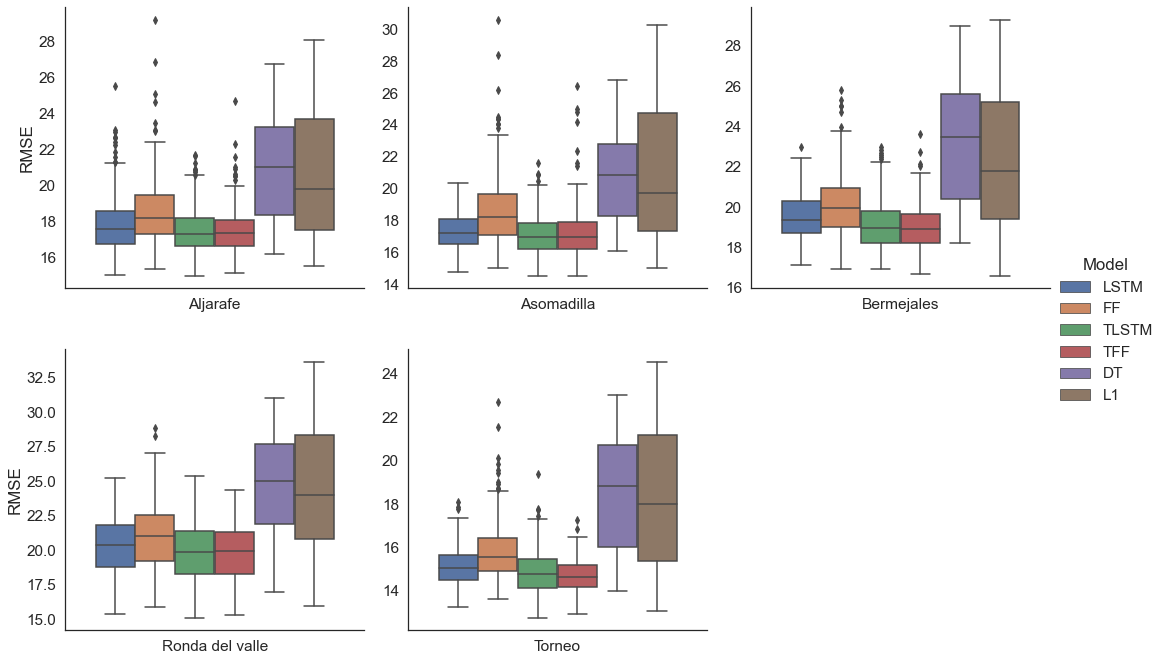

In [6]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
#total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)
total_metrics = total_metrics.rename({'model_name': 'Model', 'root_mean_squared_error': 'RMSE', 'n_features': '# Features'}, axis=1)
g = sns.catplot(data=total_metrics, kind='box', x='dataset', y="RMSE", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()

<Figure size 1440x1440 with 0 Axes>

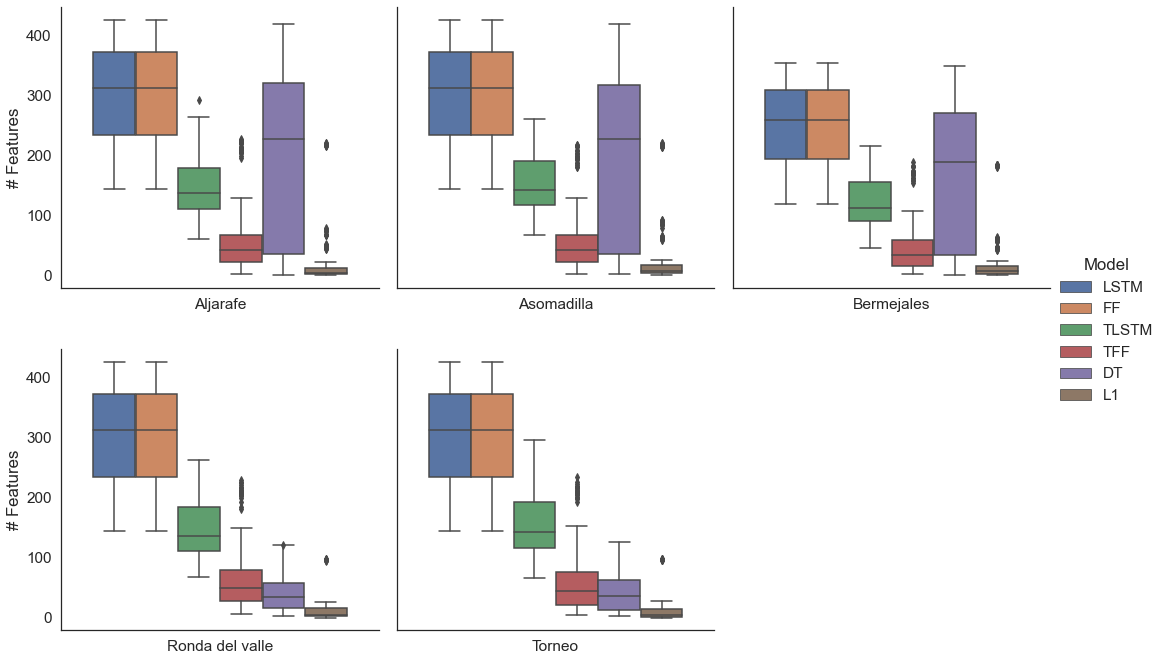

In [7]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)

g = sns.catplot(data=total_metrics[(total_metrics.dataset_params_test_year>2005)], kind='box', x='dataset', y="# Features", col='dataset', hue='Model', sharex=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.savefig('figures/boxplot_Features.png')
plt.show()
plt.show()

## Selection masks

0.359375
0.4948717948717949
0.48
0.4812206572769953
0.57981220657277


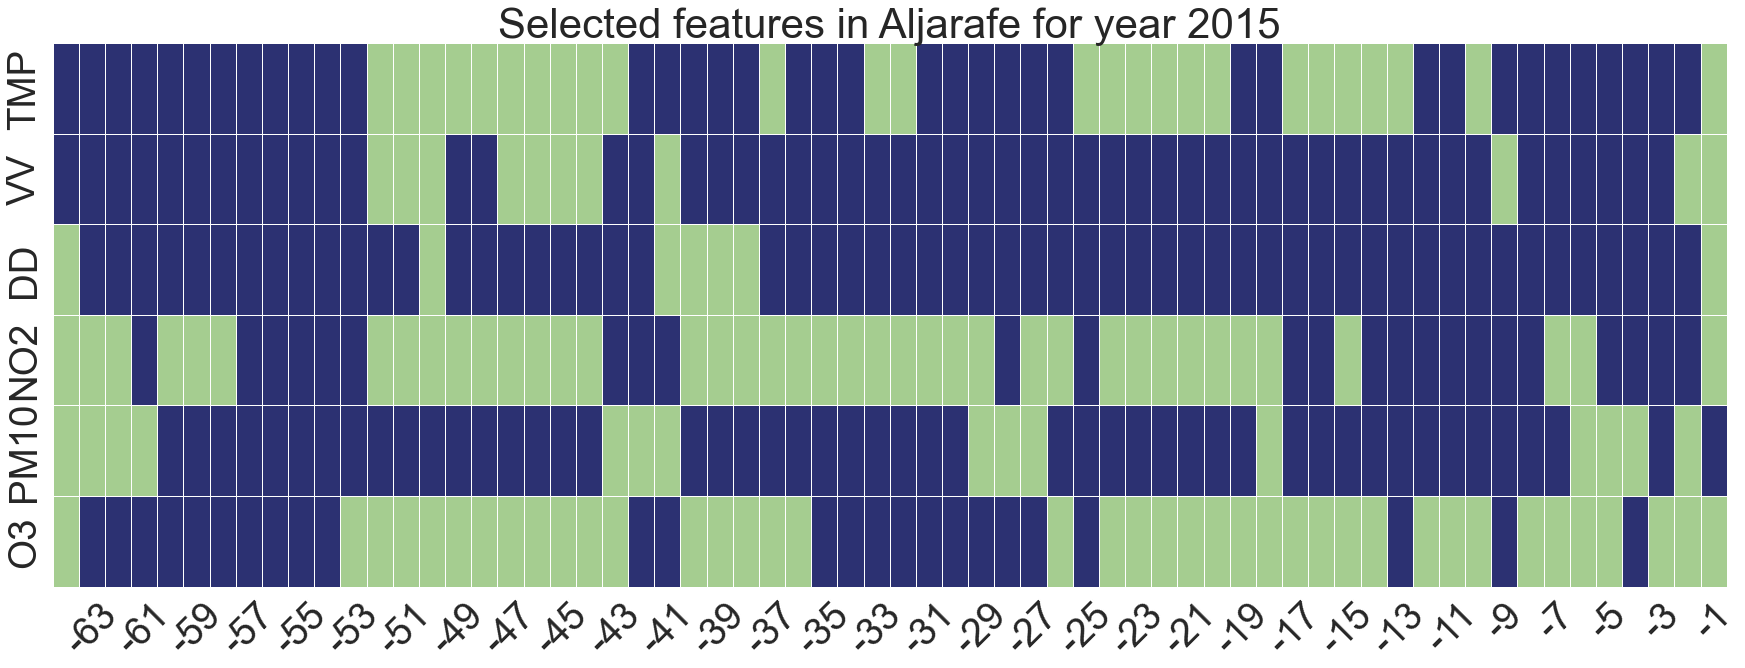

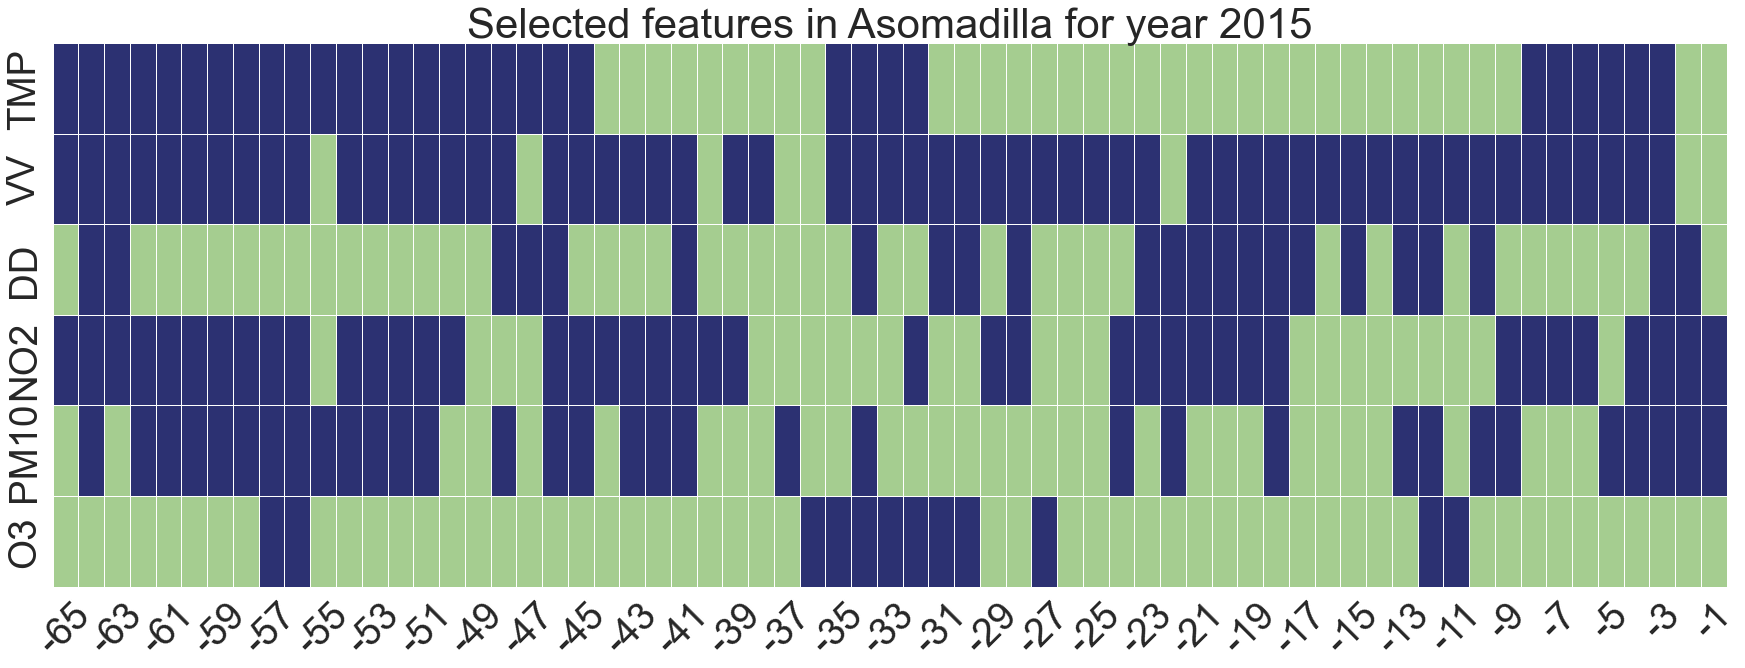

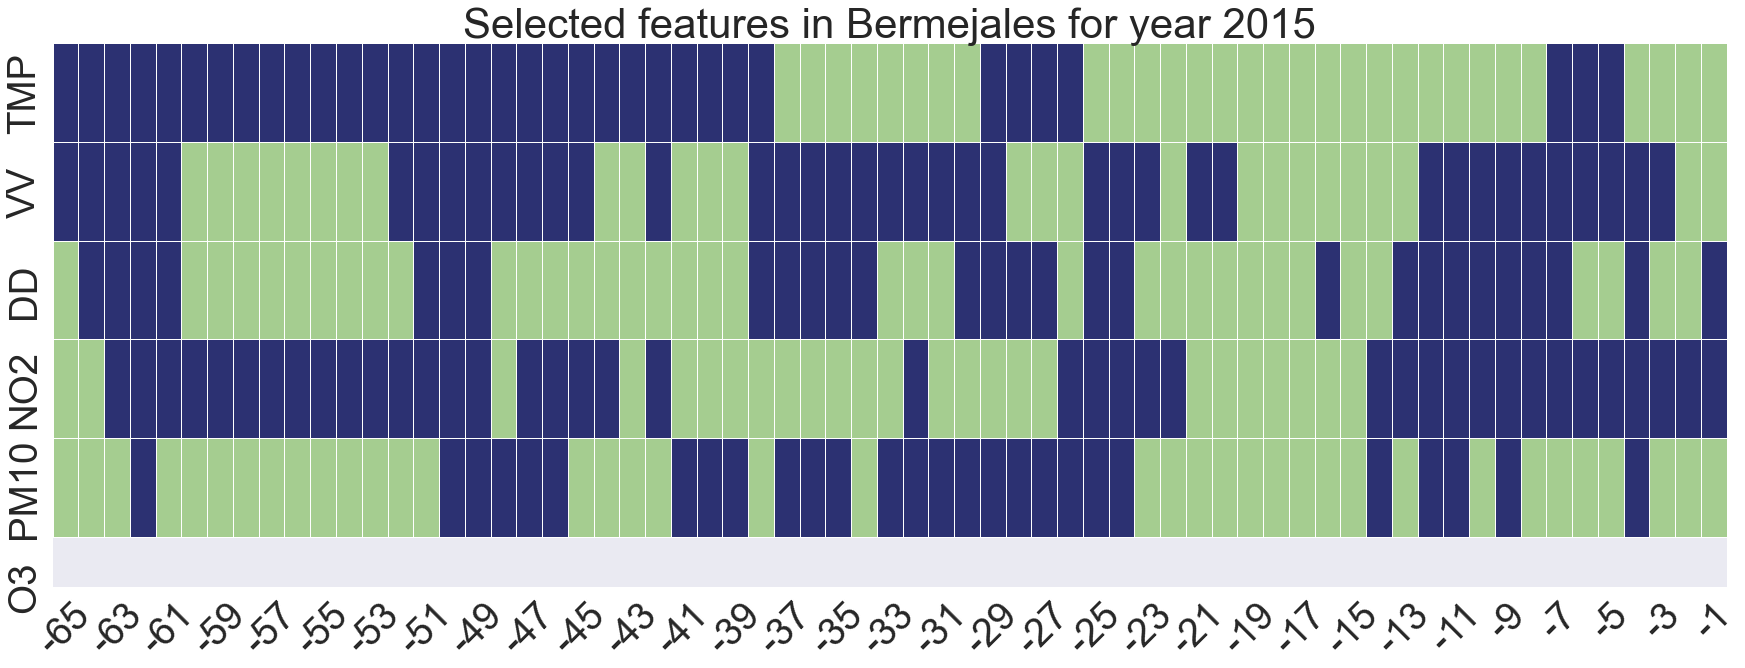

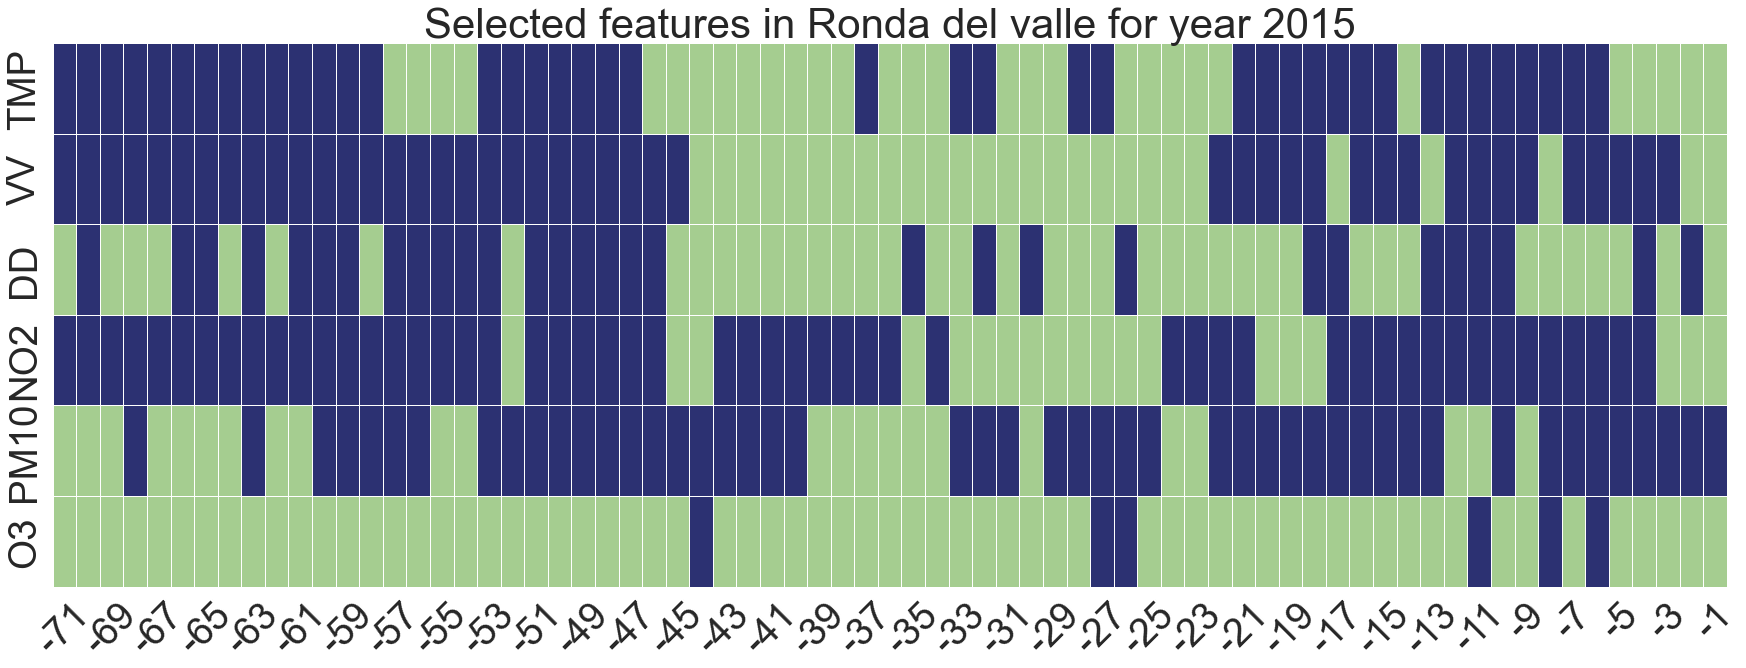

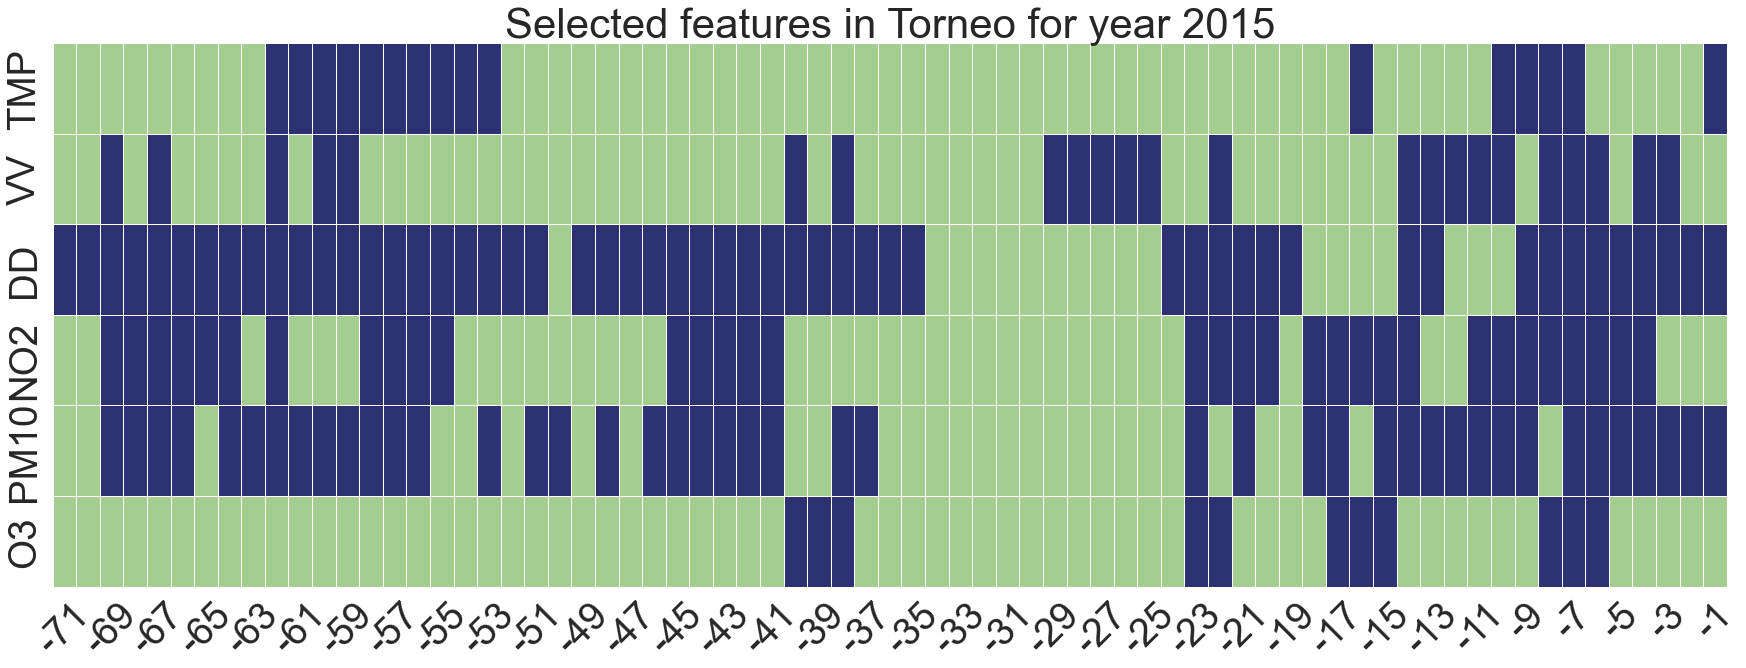

In [7]:
sns.set(font_scale=3.5)
best_by_year_selected = best_by_year[best_by_year.dataset_params_test_year>2005]

fetures_list = ['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_by_year_selected.dataset.unique():
    results_tsl_dataset = best_by_year_selected[(best_by_year_selected.dataset==dataset) & (best_by_year_selected.model_name=='TLSTM')].sort_values('dataset_params_test_year')
    results_tsl_dataset1 = best_by_year_selected[best_by_year_selected['dataset_params_test_year']==2015]
    features = results_tsl_dataset.features.apply(eval).apply(np.array).values[0]
    selected_features = results_tsl_dataset.selected_features.apply(eval).apply(np.array).values[0]

    selection_masks = []
    for feat in fetures_list:
        
        feats = features[np.core.defchararray.find(features, feat)!=-1]
        if len(feats)==0:
            continue
        sfeats = selected_features[np.core.defchararray.find(selected_features, feat)!=-1]

        
        mask = np.isin(feats, sfeats).astype(np.uint)
        selection_masks.append(mask)
    
    selection_masks = np.stack(selection_masks)
    print(selection_masks.sum()/(selection_masks.shape[0]*selection_masks.shape[1]))
    fig, ax = plt.subplots(figsize=(30,10))

    ax.set_title(f'Selected features in {dataset} for year 2015')
    cmap = sns.cm.crest_r
    feats[-2::-2] = ''
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), fetures_list)),cmap=cmap, xticklabels=list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist())), cbar=False, linewidth=.5, ax=ax)
    plt.xticks(rotation=45)
    fig = g.get_figure()
    fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 

## Results by year

In [5]:

best_metrics = total_metrics_indexed.loc[best_index].reset_index()
best_metrics = best_metrics.groupby(['dataset', 'model_name', 'dataset_params_test_year'], dropna=False)[['root_mean_squared_error']].mean().reset_index()
best_metrics = best_metrics.rename({'dataset_params_test_year': 'year'}, axis=1)
best_metrics = best_metrics[(best_metrics.year>2005)]
best_metrics = best_metrics[best_metrics.model_name.isin(["L1", "TFF", "TLSTM"])]
best_metrics.pivot(index = ['year'], columns=[ 'dataset','model_name'], values='root_mean_squared_error').round(1)#.to_latex()

dataset    Aljarafe             Asomadilla             Bermejales              \
model_name       L1   TFF TLSTM         L1   TFF TLSTM         L1   TFF TLSTM   
year                                                                            
2006           17.5  17.4  17.4       17.5  18.3  18.2       18.4  18.8  18.0   
2007           15.8  16.4  16.1       16.5  16.6  16.3       18.6  19.3  18.3   
2008           17.0  17.0  17.0       17.3  17.3  17.1       19.1  18.3  18.3   
2009           16.8  16.9  17.4       16.3  16.6  16.2       18.8  19.2  18.6   
2010           17.1  17.0  16.4       16.2  16.5  15.4       20.1  19.3  19.8   
2011           15.9  16.2  15.3       16.8  16.7  17.6       17.4  17.0  17.2   
2012           17.1  17.1  17.0       15.9  15.7  15.4       18.0  18.1  18.1   
2013           15.5  15.7  15.0       15.0  15.5  15.1       17.8  17.2  17.6   
2014           15.8  15.5  15.5       16.2  16.4  16.0       17.3  17.3  17.7   
2015           18.2  17.5  16.1       15.6  15.6  15.5       16.6  16.8  17.4   

dataset    Ronda del valle             Torneo              
model_name              L1   TFF TLSTM     L1   TFF TLSTM  
year                                                       
2006                  20.0  19.6  19.7   13.3  13.1  13.5  
2007                  19.5  19.4  19.2   13.4  13.4  13.3  
2008                  20.4  20.5  20.0   13.3  13.6  13.4  
2009                  19.0  19.1  18.7   14.1  14.0  14.1  
2010                  20.9  19.6  20.1   14.5  14.5  15.1  
2011                  18.5  18.5  18.5   14.4  14.1  14.0  
2012                  15.9  15.6  15.1   15.0  14.6  14.5  
2013                  17.2  17.0  16.9   14.4  14.3  14.0  
2014                  17.9  17.5  17.4   14.3  14.0  14.1  
2015                  17.5  17.4  17.1   14.8  14.4  14.3

## Bayesian tests

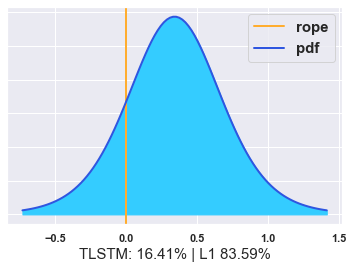

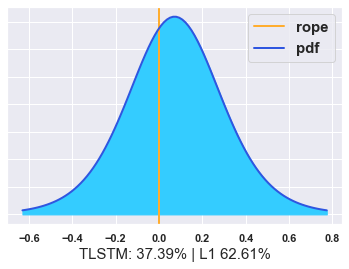

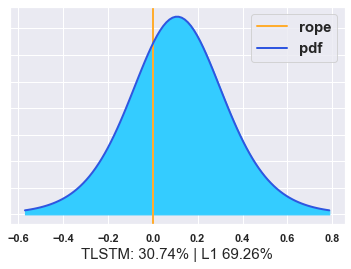

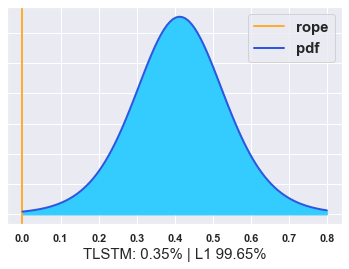

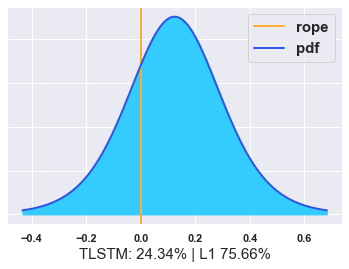

In [36]:
from baycomp import two_on_single
import matplotlib

import matplotlib.pyplot as plt



for dataset in best_metrics.dataset.unique():
    metrics_tsl = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='TLSTM')].root_mean_squared_error.values
    metrics_l1 = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='L1')].root_mean_squared_error.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, names=['TLSTM', 'L1'], plot=True)
    plt.xlabel(f'TLSTM: {round(probs[0]*100, 2)}% | L1 {round(probs[1]*100, 2)}%', fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png") 

## Best hyperparameters

In [9]:
best_hyperparameters = best_by_year.reset_index().groupby(['dataset', 'model_name']).head(1).reset_index()

In [10]:
pd.set_option('display.max_colwidth', 2000)
params = list(map(lambda my_dict: {k: my_dict[k] if not my_dict[k].is_integer() else int(my_dict[k]) for k in my_dict if not isnan(my_dict[k])},best_index.to_frame()[best_index.to_frame().model_name!='TSLRes'].loc[:, ['model_params_layers', 'model_params_units', 'model_params_batch_size', 'model_params_lr','model_params_dropout',  'model_params_max_depth', 'model_params_regularization','selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = best_hyperparameters.dataset_params_seq_len #
best_hyperparameters['params'] = params

best_hyperparameters[["dataset", "model_name", "window", "params"]].set_index(['dataset', 'model_name', 'window'])#[best_hyperparameters.model_name=="TSL+LSTM"].set_index(['dataset']).to_dict('index')#.to_latex('tab.tex')

params
dataset         model_name window                                                                                                                                                                                                                               
Aljarafe        DT         45                                                                                                                                                                                                      {'model_params_max_depth': 5}
                FF         39                                                            {'model_params_layers': 1, 'model_params_units': 35, 'model_params_batch_size': 117, 'model_params_lr': 0.0062097346448451, 'model_params_dropout': 0.2868397433361429}
                L1         38                                                                                                                                                                                {'model_params_regularization': 0.0001143748173448}
                LSTM       67                                                             {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 90, 'model_params_lr': 0.0059068949009697, 'model_params_dropout': 0.2574445560291543}
                TSL+FF     51      {'model_params_layers': 1, 'model_params_units': 16, 'model_params_batch_size': 95, 'model_params_lr': 0.0008125453689259, 'model_params_dropout': 0.2798584910270712, 'selection_params_regularization': 0.0096727665723697}
                TSL+LSTM   64      {'model_params_layers': 1, 'model_params_units': 18, 'model_params_batch_size': 44, 'model_params_lr': 0.0058554533800052, 'model_params_dropout': 0.3719129270375464, 'selection_params_regularization': 0.0097002028888842}
Asomadilla      DT         25                                                                                                                                                                                                      {'model_params_max_depth': 4}
                FF         32                                                            {'model_params_layers': 1, 'model_params_units': 56, 'model_params_batch_size': 114, 'model_params_lr': 0.0004866423540055, 'model_params_dropout': 0.4473033317519236}
                L1         56                                                                                                                                                                                {'model_params_regularization': 0.0273875931979261}
                LSTM       68                                                             {'model_params_layers': 1, 'model_params_units': 24, 'model_params_batch_size': 31, 'model_params_lr': 0.0017370065514576, 'model_params_dropout': 0.4036956443547619}
                TSL+FF     64      {'model_params_layers': 1, 'model_params_units': 18, 'model_params_batch_size': 44, 'model_params_lr': 0.0058554533800052, 'model_params_dropout': 0.3719129270375464, 'selection_params_regularization': 0.0097002028888842}
                TSL+LSTM   65      {'model_params_layers': 1, 'model_params_units': 36, 'model_params_batch_size': 29, 'model_params_lr': 0.0003802342314058, 'model_params_dropout': 0.0099400669198977, 'selection_params_regularization': 0.0024621860549236}
Bermejales      DT         45                                                                                                                                                                                                      {'model_params_max_depth': 5}
                FF         32                                                            {'model_params_layers': 1, 'model_params_units': 56, 'model_params_batch_size': 114, 'model_params_lr': 0.0004866423540055, 'model_params_dropout': 0.4473033317519236}
                L1         38                                                                                                             